# *contents*

- 加载数据
- 历史夏普比率
- 不同时间窗口的夏普比率

In [1]:
%matplotlib inline
import logging
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import helper
import pprint
import log_setup

helper.chinese_font_setup()
log_setup.setup()

In [2]:
datainfo, datainfo_abbr = helper.datafiles_info_v2()
datainfo

{'510050.SH': DataInfo(code='510050.SH', name='上证50ETF', abbr='SZ50ETF', path='./datafiles/510050.SH_2005-02-23_2023-06-26.xlsx', first='2005-02-23', last='2023-06-26'),
 '510300.SH': DataInfo(code='510300.SH', name='沪深300ETF', abbr='HS300ETF', path='./datafiles/510300.SH_2012-05-28_2023-06-26.xlsx', first='2012-05-28', last='2023-06-26'),
 '510500.SH': DataInfo(code='510500.SH', name='中证500ETF', abbr='ZZ500ETF', path='./datafiles/510500.SH_2013-03-15_2023-06-26.xlsx', first='2013-03-15', last='2023-06-26'),
 '159915.SZ': DataInfo(code='159915.SZ', name='创业板ETF', abbr='CYBETF', path='./datafiles/159915.SZ_2011-12-09_2023-06-26.xlsx', first='2011-12-09', last='2023-06-26'),
 '159949.SZ': DataInfo(code='159949.SZ', name='创业板50ETF', abbr='CYB50ETF', path='./datafiles/159949.SZ_2016-07-22_2023-06-26.xlsx', first='2016-07-22', last='2023-06-26'),
 '588000.SH': DataInfo(code='588000.SH', name='科创50ETF', abbr='KC50ETF', path='./datafiles/588000.SH_2020-11-16_2023-06-26.xlsx', first='2020-11-1

In [3]:
def build_big_df():
    series = []
    keys = []
    for di in datainfo.values():
        df = pd.read_excel(di.path, header=0, index_col=0)
        logging.info('{} {}'.format(di.name, df.shape))
        keys.append(di.code)
        series.append(df.close)
    df = pd.concat(series, axis=1, keys=keys)
    logging.info('result df shape: {}'.format(df.shape))
    return df

df = build_big_df().iloc[:,:9]
df.describe()

[2023-06-27 14:14:29,162] [INFO]	[1540912148.py:6:build_big_df] 上证50ETF (4459, 7)
[2023-06-27 14:14:29,573] [INFO]	[1540912148.py:6:build_big_df] 沪深300ETF (2694, 7)
[2023-06-27 14:14:29,957] [INFO]	[1540912148.py:6:build_big_df] 中证500ETF (2498, 7)
[2023-06-27 14:14:30,381] [INFO]	[1540912148.py:6:build_big_df] 创业板ETF (2802, 7)
[2023-06-27 14:14:30,628] [INFO]	[1540912148.py:6:build_big_df] 创业板50ETF (1682, 7)
[2023-06-27 14:14:30,736] [INFO]	[1540912148.py:6:build_big_df] 科创50ETF (633, 7)
[2023-06-27 14:14:31,147] [INFO]	[1540912148.py:6:build_big_df] 黄金ETF (2411, 7)
[2023-06-27 14:14:31,234] [INFO]	[1540912148.py:6:build_big_df] 双创50ETF (479, 7)
[2023-06-27 14:14:31,304] [INFO]	[1540912148.py:6:build_big_df] A50ETF (396, 7)
[2023-06-27 14:14:31,527] [INFO]	[1540912148.py:6:build_big_df] 宁德时代 (1224, 7)
[2023-06-27 14:14:31,725] [INFO]	[1540912148.py:6:build_big_df] 迈瑞医疗 (1140, 7)
[2023-06-27 14:14:32,195] [INFO]	[1540912148.py:6:build_big_df] 东方财富 (3159, 7)
[2023-06-27 14:14:32,658] [IN

,510050.SH,510300.SH,510500.SH,159915.SZ,159949.SZ,588000.SH,518880.SH,159781.SZ,159601.SZ
count,4459.000000,2694.000000,2498.000000,2802.000000,1682.000000,633.000000,2411.000000,479.000000,396.000000
mean,2.022616,3.370422,5.394152,1.856577,0.899382,1.258196,3.074347,0.701422,0.856270
std,0.761404,0.926770,1.193915,0.700593,0.299823,0.197158,0.602777,0.121696,0.071738
min,0.517918,1.813988,2.819713,0.598000,0.425000,0.909000,2.167000,0.534000,0.721000
25%,1.448315,2.797733,4.632969,1.363000,0.661500,1.075000,2.620000,0.609000,0.803750
50%,1.992616,3.445592,5.634934,1.767500,0.834000,1.218000,2.783000,0.653000,0.842500
75%,2.656792,3.954767,6.176500,2.349750,1.111750,1.425000,3.669500,0.830500,0.894250
max,3.905555,5.629466,10.218341,3.790000,1.585000,1.670000,4.415000,0.994000,1.036000


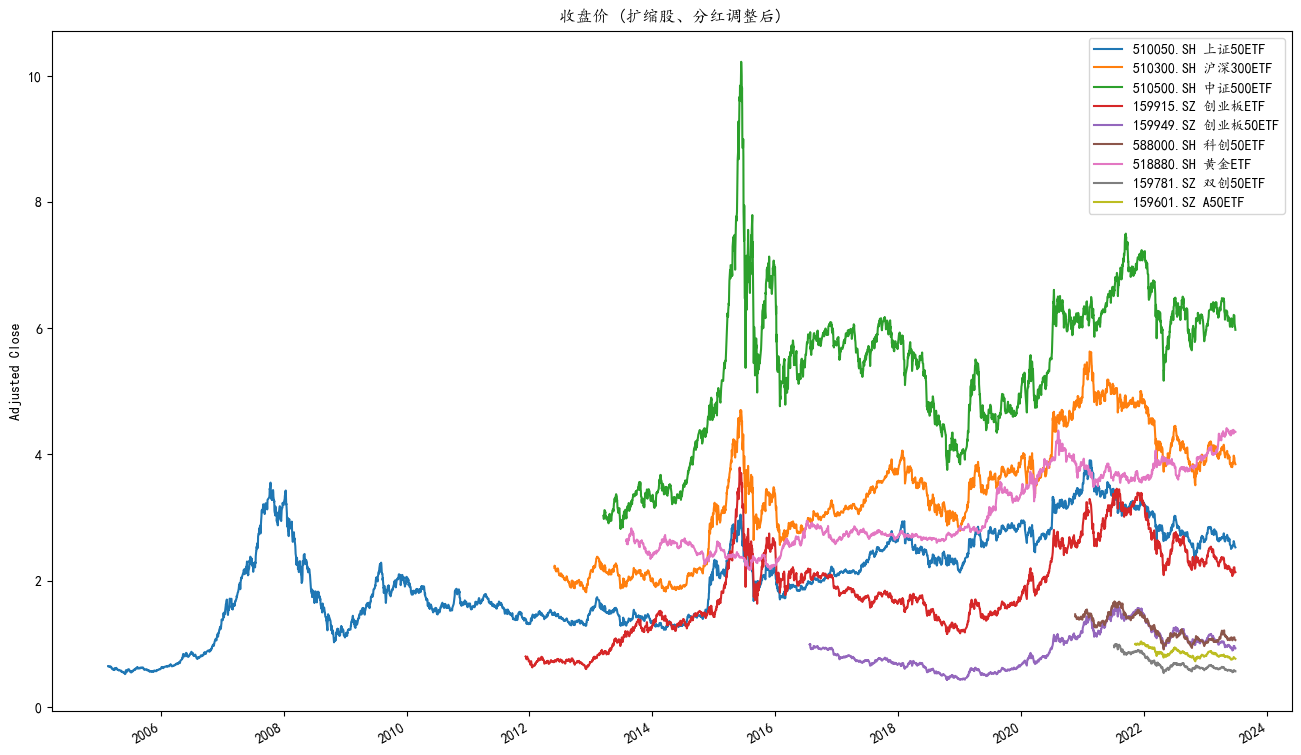

In [4]:
df2 = df.rename(
    columns=dict([ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo.values() ])
).plot(figsize=(16,10), ylabel='Adjusted Close', title='收盘价 (扩缩股、分红调整后)')

# *历史夏普比率*

此处 <font color=red>假设无风险利率为2%</font>。

In [5]:
k_annual_risk_free_rate = 0.02
k_days_per_year = 252

In [6]:
def historical_sharpe_ratio(df, annual_risk_free_rate=k_annual_risk_free_rate):
    print('历史夏普比率')
    for code in df.columns:
        price = df[code]
        daily_ret = price.pct_change()
        daily_excess_ret = daily_ret - annual_risk_free_rate / k_days_per_year
        sharpe_ratio = daily_excess_ret.mean() / daily_excess_ret.std() * np.sqrt(k_days_per_year)
        print('{} {}:\t{:8.5f}'.format(code, datainfo[code].name, sharpe_ratio))
historical_sharpe_ratio(df, k_annual_risk_free_rate)

历史夏普比率
510050.SH 上证50ETF:	 0.34870
510300.SH 沪深300ETF:	 0.25495
510500.SH 中证500ETF:	 0.31650
159915.SZ 创业板ETF:	 0.37349
159949.SZ 创业板50ETF:	 0.03967
588000.SH 科创50ETF:	-0.49066
518880.SH 黄金ETF:	 0.31765
159781.SZ 双创50ETF:	-1.14700
159601.SZ A50ETF:	-0.89910


# *滑动窗口夏普比率*

In [7]:
def annualized_sharpe_ratio(rolling_window = 30,
                            annual_risk_free_rate = k_annual_risk_free_rate,
                            time_range = None,
                            symbols = None):
    if symbols is not None:
        price = df[symbols]
    else:
        price = df

    if time_range is not None:
        price = price[time_range[0] : time_range[1]]

    figsize = (16,6)
    rename_dict = dict([ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo.values() ])

    price = price.copy()
    excess_return  = price.pct_change() - annual_risk_free_rate / k_days_per_year
    rolling_mean   = excess_return.rolling(window = rolling_window).mean()
    rolling_std    = excess_return.rolling(window = rolling_window).std()
    rolling_sharpe = rolling_mean / rolling_std #* np.sqrt(k_days_per_year)

    first_values = []
    for n in price.columns:
        v = price.loc[ price[n].first_valid_index(), n ]
        first_values.append(v)
    #price = price / price.iloc[0,:] # make all price starts from 1.0
    price = price / first_values # make all price starts from 1.0
    price.rename(columns = rename_dict, inplace = True)
    price.plot(figsize = figsize, ylabel = 'daily price', grid = True)
    
    rolling_std.rename(columns = rename_dict, inplace = True)
    rolling_std.plot(figsize = figsize, ylabel = 'volatility', grid = True)
    
    rolling_sharpe.rename(columns = rename_dict, inplace = True)
    rolling_sharpe.plot(figsize = figsize,
                        ylabel = 'Annualized Sharpe Ratio',
                        title = '夏普比率 ( 滑动窗口 = {}日, 无风险利率 $r_F$ = {:.2f} % )'.format(
                            rolling_window, annual_risk_free_rate*100),
                        grid = True)

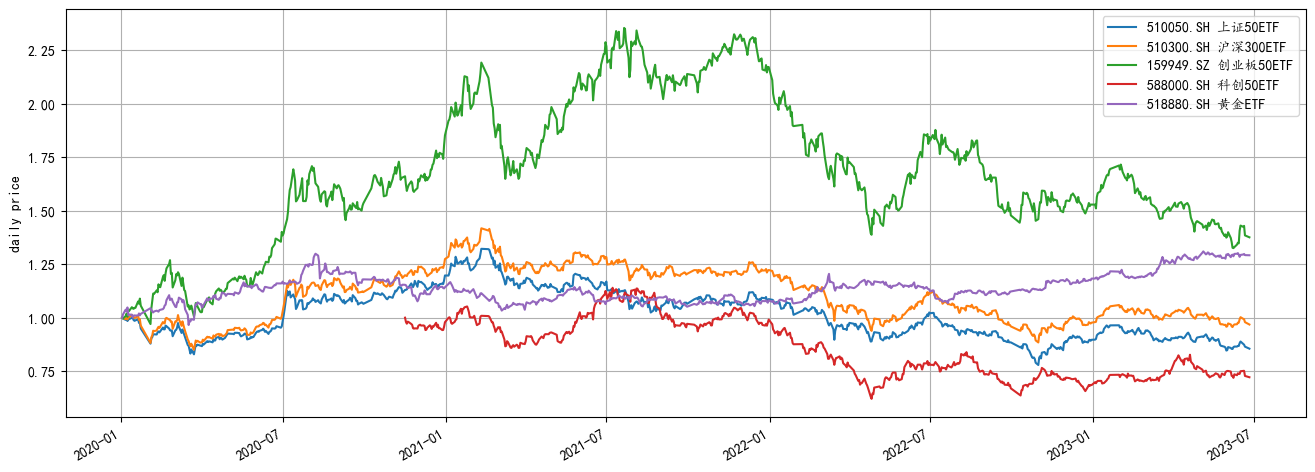

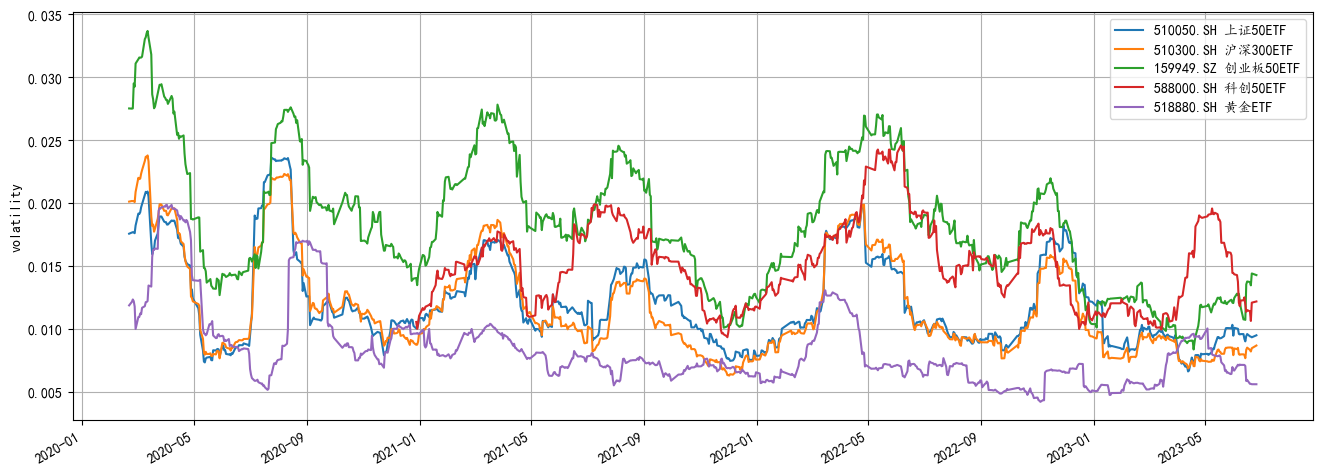

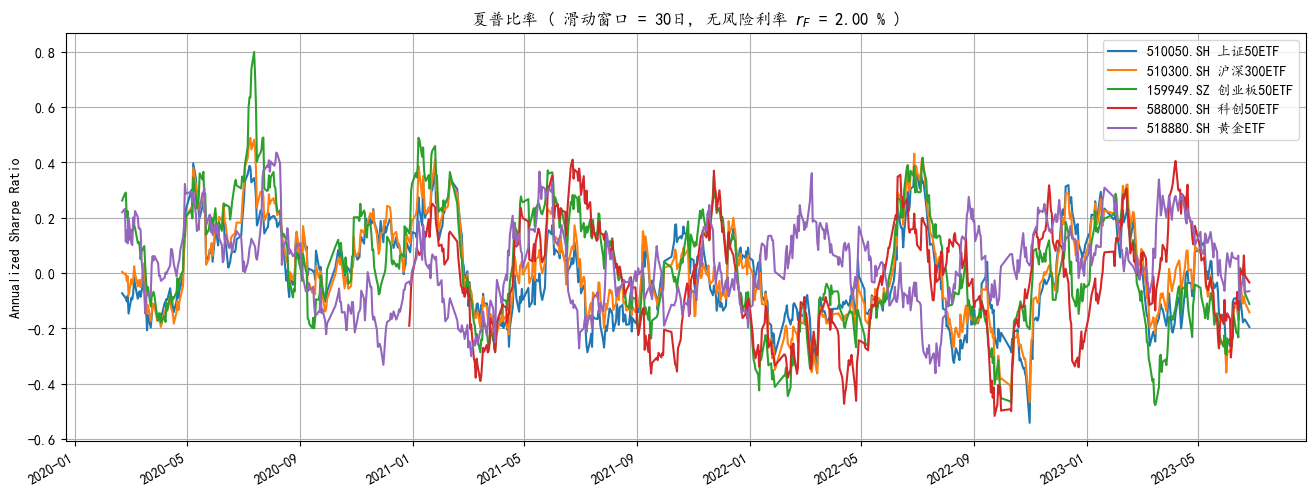

In [8]:
symbols = [
    '510050.SH',
    '510300.SH',
    '159949.SZ',
    '588000.SH',
    '518880.SH',
]

annualized_sharpe_ratio(30,
                        time_range = ['2020', '2023'],
                        symbols = symbols,
                       )